In [2]:
import tensorflow as tf
import numpy as np
import cPickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict
batch1 = unpickle('cifar-10-batches-py/data_batch_1')

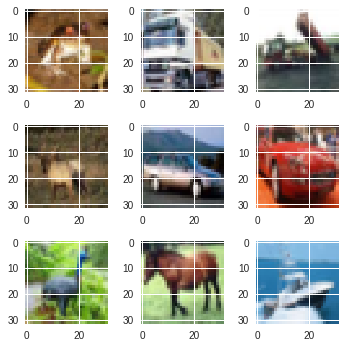

In [4]:
# print for 9 images
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = batch1['data'][i].reshape([3, 32, 32])
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
fig.tight_layout()        
plt.show()

In [5]:
# define our hyper-parameters
BATCH_SIZE = 32
# image size
IMG_SIZE = 32
# Number of residual block per group.
# Total number of conv layers will be 6n + 4
RESIDUAL_UNITS = 2
# Network width multiplier
WIDTH_MULTIPLIER = 2
# L2 loss weight applied all the weights
L2_WEIGHT = 0.0001
# The momentum of MomentumOptimizer
MOMENTUM = 0.9
# initial learning rate
LEARNING_RATE = 0.1
# every this step will happen decay
LR_STEP_DECAY = 100
# how much our learning rate decay
LR_DECAY = 0.1
# got 10
NUM_CLASSES = 10

In [6]:
def relu(x, name, alpha = 0.0):
    if alpha > 0.0:
        return tf.nn.relu(x, name = 'relu_' + name)
    else:
        return tf.maximum(x * alpha, x, name = 'leaky_relu_' + name)
    
def conv_layer(x, conv, out_shape, name, stride = 1):
    w = tf.Variable(tf.random_normal([conv, conv, int(x.shape[3]), out_shape], 
                                     stddev = np.sqrt(2.0 / conv / conv / out_shape)), name = name + '_w')
    return tf.nn.conv2d(x, w, [1, stride, stride, 1], padding = 'SAME')

def fully_connected(x, out_shape, name):
    w = tf.Variable(tf.random_normal([int(x.shape[1]), out_shape], 
                                     stddev = np.sqrt(1.0 / out_shape)), name = name + '_fc_w')
    b = tf.Variable(tf.zeros([out_shape]), name = name + '_fc_b')
    return tf.matmul(x, w) + b

In [ ]:
def resnet(x, name, reuse = False, train = True, alpha = 0.0):
    filters = [16, 16 * WIDTH_MULTIPLIER, 32 * WIDTH_MULTIPLIER, 64 * WIDTH_MULTIPLIER]
    strides = [1, 2, 2]
    x = conv_layer(x, 3, 16, name = 'init_conv', stride = 1)
    
    for i in range(1, 4, 1):
        with tf.variable_scope(name + '_unit_' + str(i), reuse = reuse):
            x = tf.layers.batch_normalization(x, training = train, name = 'bn_1')
            x = relu(x, 'relu_1')
            if filters[i - 1] == filters[i]:
                if strides[i - 1] == 1:
                    shortcut = tf.identity(x)
                else:
                    shortcut = tf.nn.max_pool(x, [1, strides[i-1], strides[i-1], 1],
                                              [1, strides[i-1], strides[i-1], 1], 'VALID')
            else:
                shortcut = conv_layer(x, 1, filters[i], name = 'shortcut', stride = strides[i-1])
            x = conv_layer(x, 3, filters[i], name = 'conv_1', stride = strides[i-1])
            x = tf.layers.batch_normalization(x, training = train, name = 'bn_2')
            x = relu(x, 'relu_2')
            x = conv_layer(x, 3, filters[i], name = 'conv_2', stride = 1)
            x = x + shortcut
        for j in range(1, RESIDUAL_UNITS, 1):
            with tf.variable_scope('unit_%d_%d' % (i, j), reuse = reuse):
                shortcut = x
                x = tf.layers.batch_normalization(x, training = train, name = 'bn_1')
                x = relu(x, 'relu_1')
                x = conv_layer(x, 3, filters[i], name = 'conv_1', stride = 1)
                x = tf.layers.batch_normalization(x, training = train, name = 'bn_2')
                x = relu(x, 'relu_2')
                x = utils._conv(x, 3, filters[i], name = 'conv_2', stride = 1)
                x = x + shortcut
    with tf.variable_scope('unit_last', reuse = reuse):
        x = tf.layers.batch_normalization(x, training = train, name = 'bn_1')
        x = relu(x, 'relu_1')
        x = tf.reduce_mean(x, [1, 2])
    with tf.variable_scope('logits', reuse = reuse):
        x_shape = x.get_shape().as_list()
        x = tf.reshape(x, [-1, x_shape[1]])
        logits = fully_connected(x, NUM_CLASSES, 'fc_1')
    return logits

In [ ]:
class Model:
    
    def __init__(self):
        self.X = tf.placeholder(tf.float32, (None, IMG_SIZE, IMG_SIZE, 3))
        self.Y = tf.placeholder(tf.float32, (None, NUM_CLASSES))
        self.train = tf.placeholder(tf.bool)
        self.logits = resnet(self.X, 'resnet', reuse = False, train = self.train)
        self.output = tf.nn.softmax(self.logits)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(x, self._labels)